In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import gc

import numpy as np

sys.path.append("..")
from dm21cm.dm_params import DMParams

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")

In [3]:
"""Main evolution function."""

import os
import sys
import logging

import numpy as np
from scipy import interpolate
from astropy.cosmology import Planck18
import astropy.units as u
import jax.numpy as jnp

import py21cmfast as p21c
from py21cmfast import cache_tools

sys.path.append(os.environ['DH_DIR']) # use branch test_dm21cm
from darkhistory.spec.spectrum import Spectrum

sys.path.append("..")
import dm21cm.physics as phys
from dm21cm.dh_wrappers import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from dm21cm.data_cacher import Cacher
from dm21cm.profiler import Profiler

logging.getLogger().setLevel(logging.INFO)
logging.getLogger('21cmFAST').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [4]:
#===== utilities for evolve =====

def get_z_edges(z_max, z_min, zplusone_step_factor):
    z_s = [z_min]
    while z_s[-1] < z_max:
        z_s.append((z_s[-1] + 1.0) * zplusone_step_factor - 1.0)
    
    return np.clip(z_s[::-1], None, z_max)


def split_xray(phot_N, phot_eng):
    """Split a photon spectrum (N in bin) into bath and xray band."""

    ex_lo, ex_hi = 1e2, 1e4 # [eV]
    ix_lo = np.searchsorted(phot_eng, ex_lo) # i of first bin greater than ex_lo, excluded
    ix_hi = np.searchsorted(phot_eng, ex_hi) # i of first bin greater than ex_hi, included

    bath_N = np.array(phot_N).copy()
    xray_N = np.array(phot_N).copy()
    bath_N[ix_lo:ix_hi] *= 0
    xray_N[:ix_lo] *= 0
    xray_N[ix_hi:] *= 0
    
    return bath_N, xray_N


def gen_injection_boxes(z_next, p21c_initial_conditions):
    
    input_heating = p21c.input_heating(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    
    return input_heating, input_ionization, input_jalpha

global_astro_params = p21c.AstroParams(
    L_X = 0. # L_X = 10**0.
)

def p21c_step(perturbed_field, spin_temp, ionized_box,
             input_heating=None, input_ionization=None, input_jalpha=None):
    
    # Calculate the spin temperature, possibly using our inputs
    spin_temp = p21c.spin_temperature(
        perturbed_field = perturbed_field,
        previous_spin_temp = spin_temp,
        input_heating_box = input_heating,
        input_ionization_box = input_ionization,
        input_jalpha_box = input_jalpha,
        astro_params=global_astro_params,
    )
    
    # Calculate the ionized box
    ionized_box = p21c.ionize_box(
        perturbed_field = perturbed_field,
        previous_ionize_box = ionized_box,
        spin_temp = spin_temp,
        astro_params=global_astro_params,
    )
    
    # Calculate the brightness temperature
    brightness_temp = p21c.brightness_temperature(
        ionized_box = ionized_box,
        perturbed_field = perturbed_field,
        spin_temp = spin_temp
    )
    
    return spin_temp, ionized_box, brightness_temp

In [11]:
run_name = 'test'
z_start = 45.
z_end = 5.
zplusone_step_factor = 1.01
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-23,
    struct_boost_model = 'erfc 1e-3',
)
enable_elec = False
tf_version = '230629xc'

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 64,
        BOX_LEN = 64 * 2, # [conformal Mpc]
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 3458,
    write = True,
)

rerun_DH = False
clear_cache = True
use_tqdm = False
debug_flags = []

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [44]:
logging.info(f'Using 21cmFAST version {p21c.__version__}')

#===== cache and memory =====
p21c.config['direc'] = f"{os.environ['P21C_CACHE_DIR']}/{run_name}"
logging.info(f"Cache dir: {p21c.config['direc']}")
os.makedirs(p21c.config['direc'], exist_ok=True)
cache_tools.clear_cache()
gc.collect()

#===== initialize =====
#--- physics parameters ---
p21c.global_params.Z_HEAT_MAX = z_start
p21c.global_params.ZPRIME_STEP_FACTOR = zplusone_step_factor
p21c.global_params.CLUMPING_FACTOR = 1.
EPSILON = 1e-6

abscs = load_h5_dict(f'../data/abscissas/abscs_{tf_version}.h5')
if not np.isclose(np.log(zplusone_step_factor), abscs['dlnz']):
    raise ValueError('zplusone_step_factor and tf_version mismatch')
dm_params.set_inj_specs(abscs)

box_dim = p21c_initial_conditions.user_params.HII_DIM
box_len = p21c_initial_conditions.user_params.BOX_LEN
cosmo = Planck18

#--- DarkHistory and transfer functions ---
dh_wrapper = DarkHistoryWrapper(
    dm_params,
    prefix = p21c.config[f'direc'],
)

#--- redshift stepping ---
z_edges = get_z_edges(z_start, z_end, p21c.global_params.ZPRIME_STEP_FACTOR)

INFO:root:Using 21cmFAST version 0.1.dev1581+g40959ca
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/test


In [45]:
#===== initial step =====
#mean_T_k, mean_x_e = dh_wrapper.match(spin_temp, ionized_box)
mean_T_k, mean_x_e = 1, 0.001
p21c.global_params.TK_at_Z_HEAT_MAX = mean_T_k
p21c.global_params.XION_at_Z_HEAT_MAX = mean_x_e

print(p21c.global_params.TK_at_Z_HEAT_MAX)
print(p21c.global_params.XION_at_Z_HEAT_MAX)

1
0.001


In [ ]:
perturbed_field = p21c.perturb_field(redshift=z_edges[0], init_boxes=p21c_initial_conditions)
spin_temp = p21c.spin_temperature(
    #perturbed_field = perturbed_field,
    previous_spin_temp = None,
    input_heating_box = None,
    input_ionization_box = None,
    input_jalpha_box = None,
    astro_params=global_astro_params,
)

In [38]:
spin_temp, ionized_box, brightness_temp = p21c_step(perturbed_field=perturbed_field, spin_temp=None, ionized_box=None)

0.65690434
0.655416 0.65851235


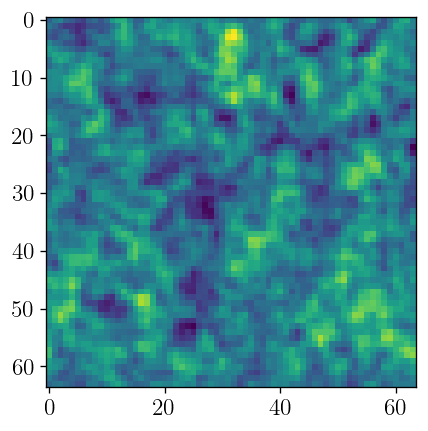

In [43]:
print(np.mean(spin_temp.Tk_box))
print(np.min(spin_temp.Tk_box), np.max(spin_temp.Tk_box))
plt.imshow(spin_temp.Tk_box[5])